In [13]:
import pandas as pd
import numpy as np
import requests
from pyjstat import pyjstat
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

In [14]:
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose


In [15]:
def decompose(df, column_name, decomp_type='additive'):
    """
    A function that returns the trend, seasonality and residual captured by applying both multiplicative and
    additive model.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    plt.rcParams.update({'figure.figsize': (20, 10)})        
    result_add = seasonal_decompose(df[column_name], model = decomp_type, extrapolate_trend='freq')
    result_add.plot().suptitle('Additive Decompose', fontsize=30)
    plt.show()
    
    return result_add

def apiToDataframe(postUrl, query):

	# postUrl som spørringen skal postes mot
	# Spørringen og endepunktet til API-et kan hentes fra Statistikkbanken.

	res = requests.post(postUrl, json=query)
	# legger resultat i ds. DS har i tillegg en del metadata
	ds = pyjstat.Dataset.read(res.text)
	# skriver resultatet til to dataframes
    # først dataframe med tekst
	df = ds.write('dataframe')
    # deretter dataframe med koder
	df_id = ds.write('dataframe', naming='id')
    # returnerer også ds i tilfelle en trenger metadata
	return df, df_id, ds

# Eksempel med tilfeldig data

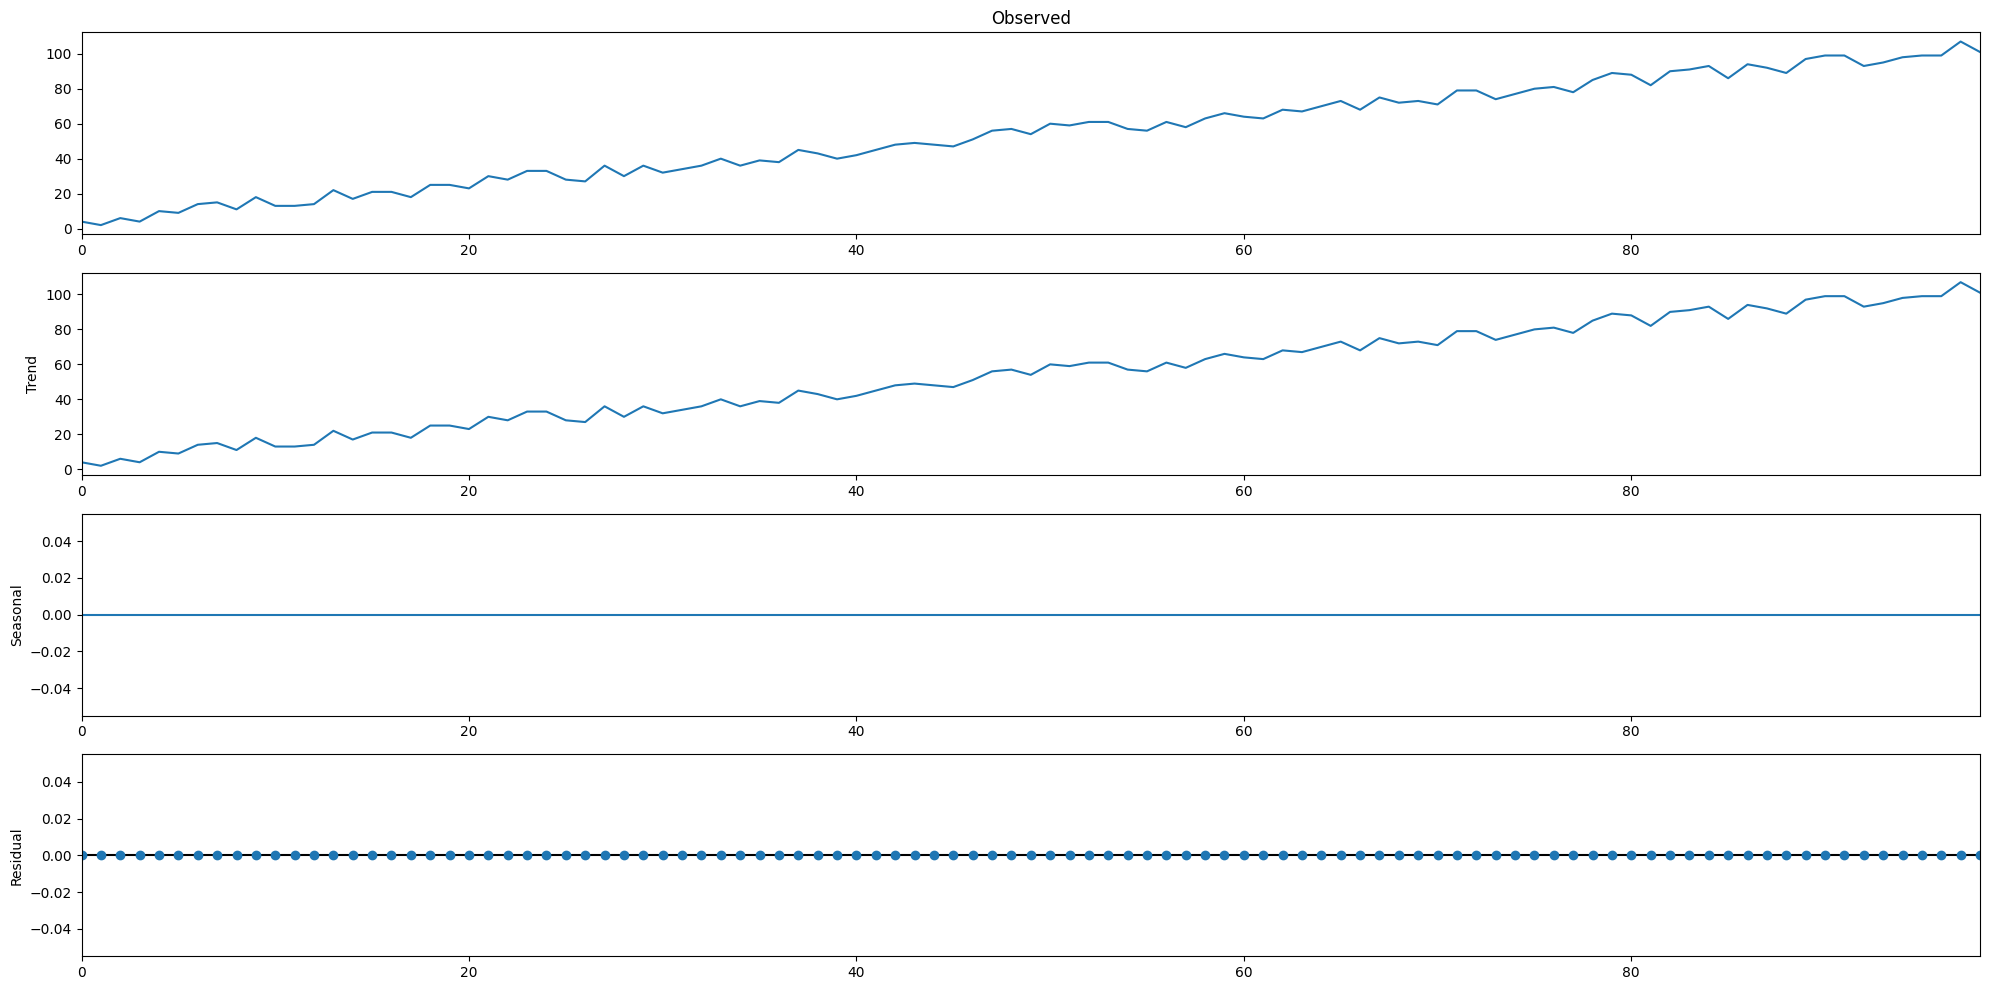

In [16]:
series = [i+randrange(10) for i in range(1,100)]
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
pyplot.show()

# Tilbake til sammenheng mellom arbeidsledighet og inflasjon

In [17]:
# ledightesrate
df, df_id, ds = apiToDataframe('https://data.ssb.no/api/v0/no/table/13760/', {
  "query": [
    {
      "code": "Kjonn",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "Justering",
      "selection": {
        "filter": "item",
        "values": [
          "IS"
        ]
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "ArbledProsArbstyrk"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
})
df['date'] = pd.to_datetime(df['måned'], format='%YM%m')
df = df[['value', 'date']]
df['value'] = df['value']/100
df = df.rename(columns={'value':'ledighet'})
df['ledighet_yoy'] = df['ledighet']/df['ledighet'].shift(12) - 1
df['ledighet_yoy_diff'] = df['ledighet_yoy'].diff()
df=df.set_index('date')
df = df.dropna()

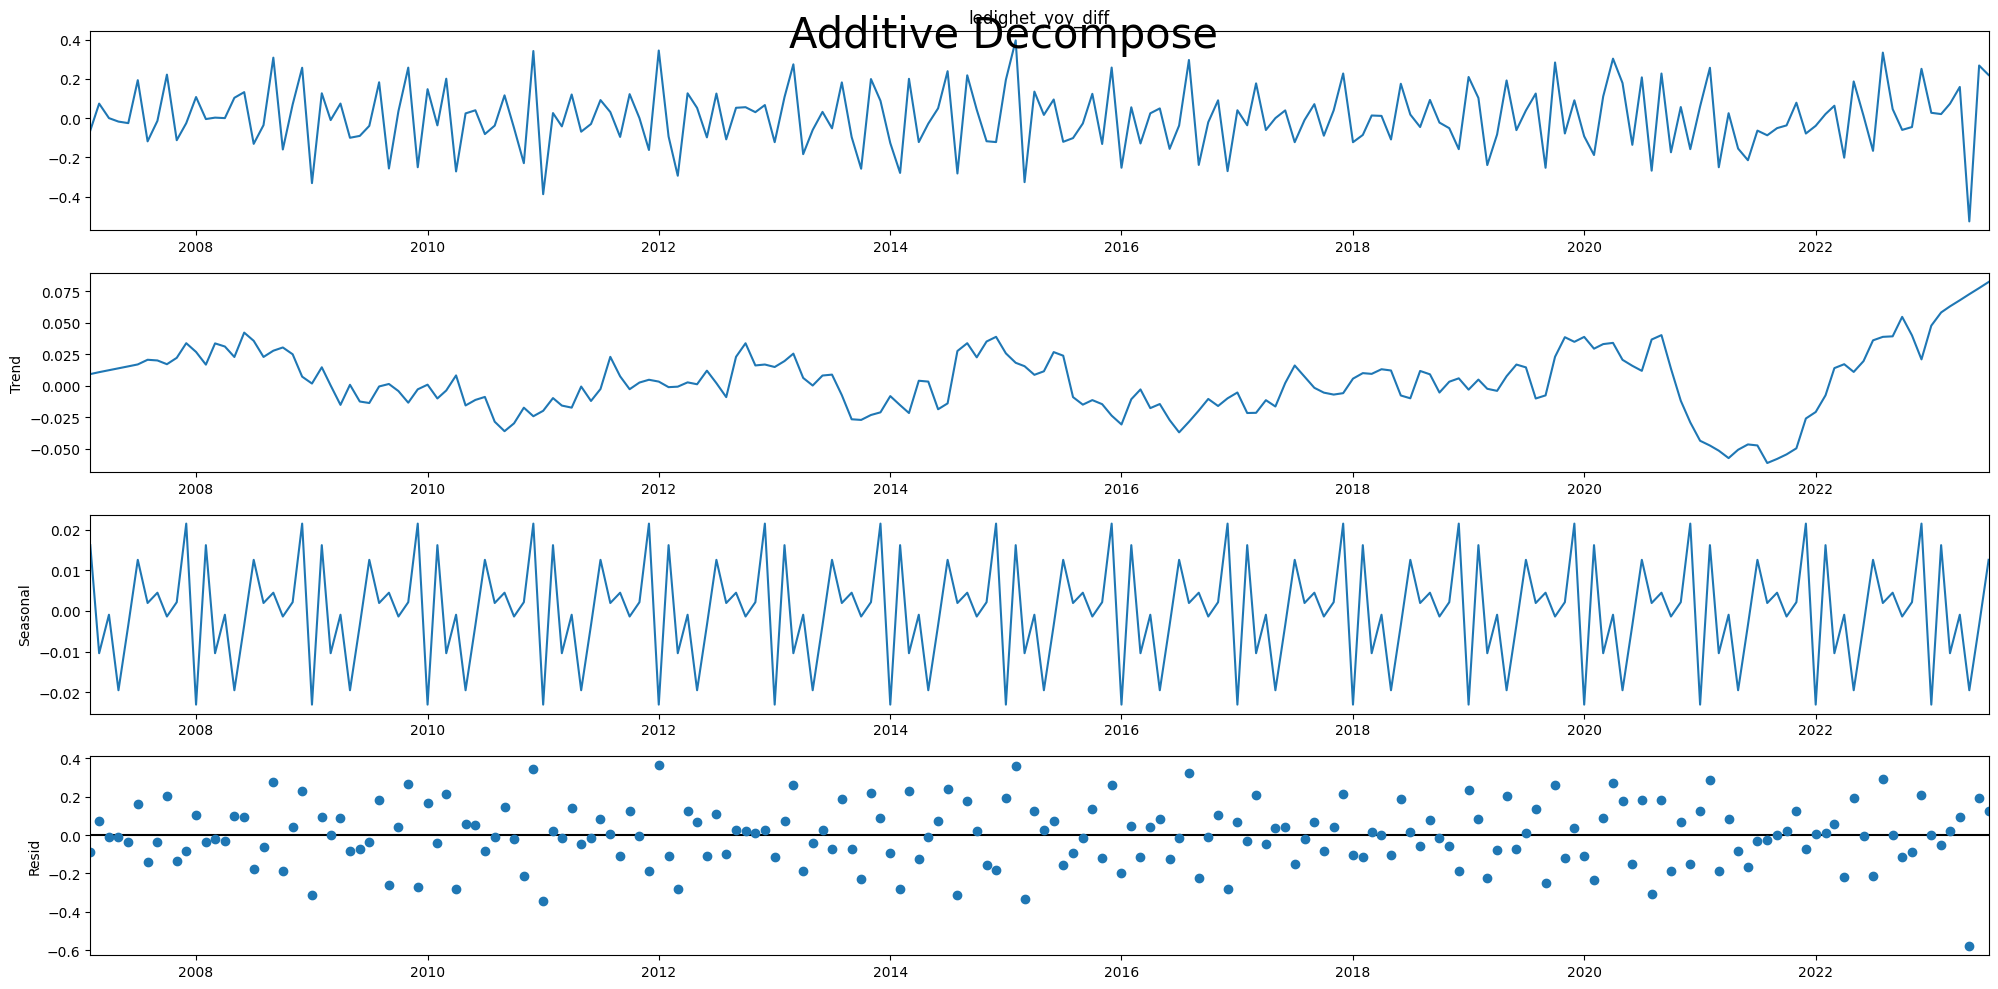

In [18]:
result_add_ledighet = decompose(df, 'ledighet_yoy_diff')

In [19]:
# KPI
df1, df_id, ds = apiToDataframe('https://data.ssb.no/api/v0/no/table/03013/', {
  "query": [
    {
      "code": "Konsumgrp",
      "selection": {
        "filter": "vs:CoiCop2016niva1",
        "values": []
      }
    },
    {
      "code": "ContentsCode",
      "selection": {
        "filter": "item",
        "values": [
          "KpiIndMnd"
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
})
df1['date'] = pd.to_datetime(df1['måned'], format='%YM%m')
#df1['value'] = df1['value']/df1['value'].shift(12) - 1 # yoy
df1 = df1[['value', 'date']]
df1 = df1.rename(columns={'value':'kpi'})
df1=df1.set_index('date')
df1['kpi_yoy'] = df1['kpi']/df1['kpi'].shift(12) - 1
df1['kpi_yoy_diff'] = df1['kpi_yoy'].diff()
df1=df1.dropna()

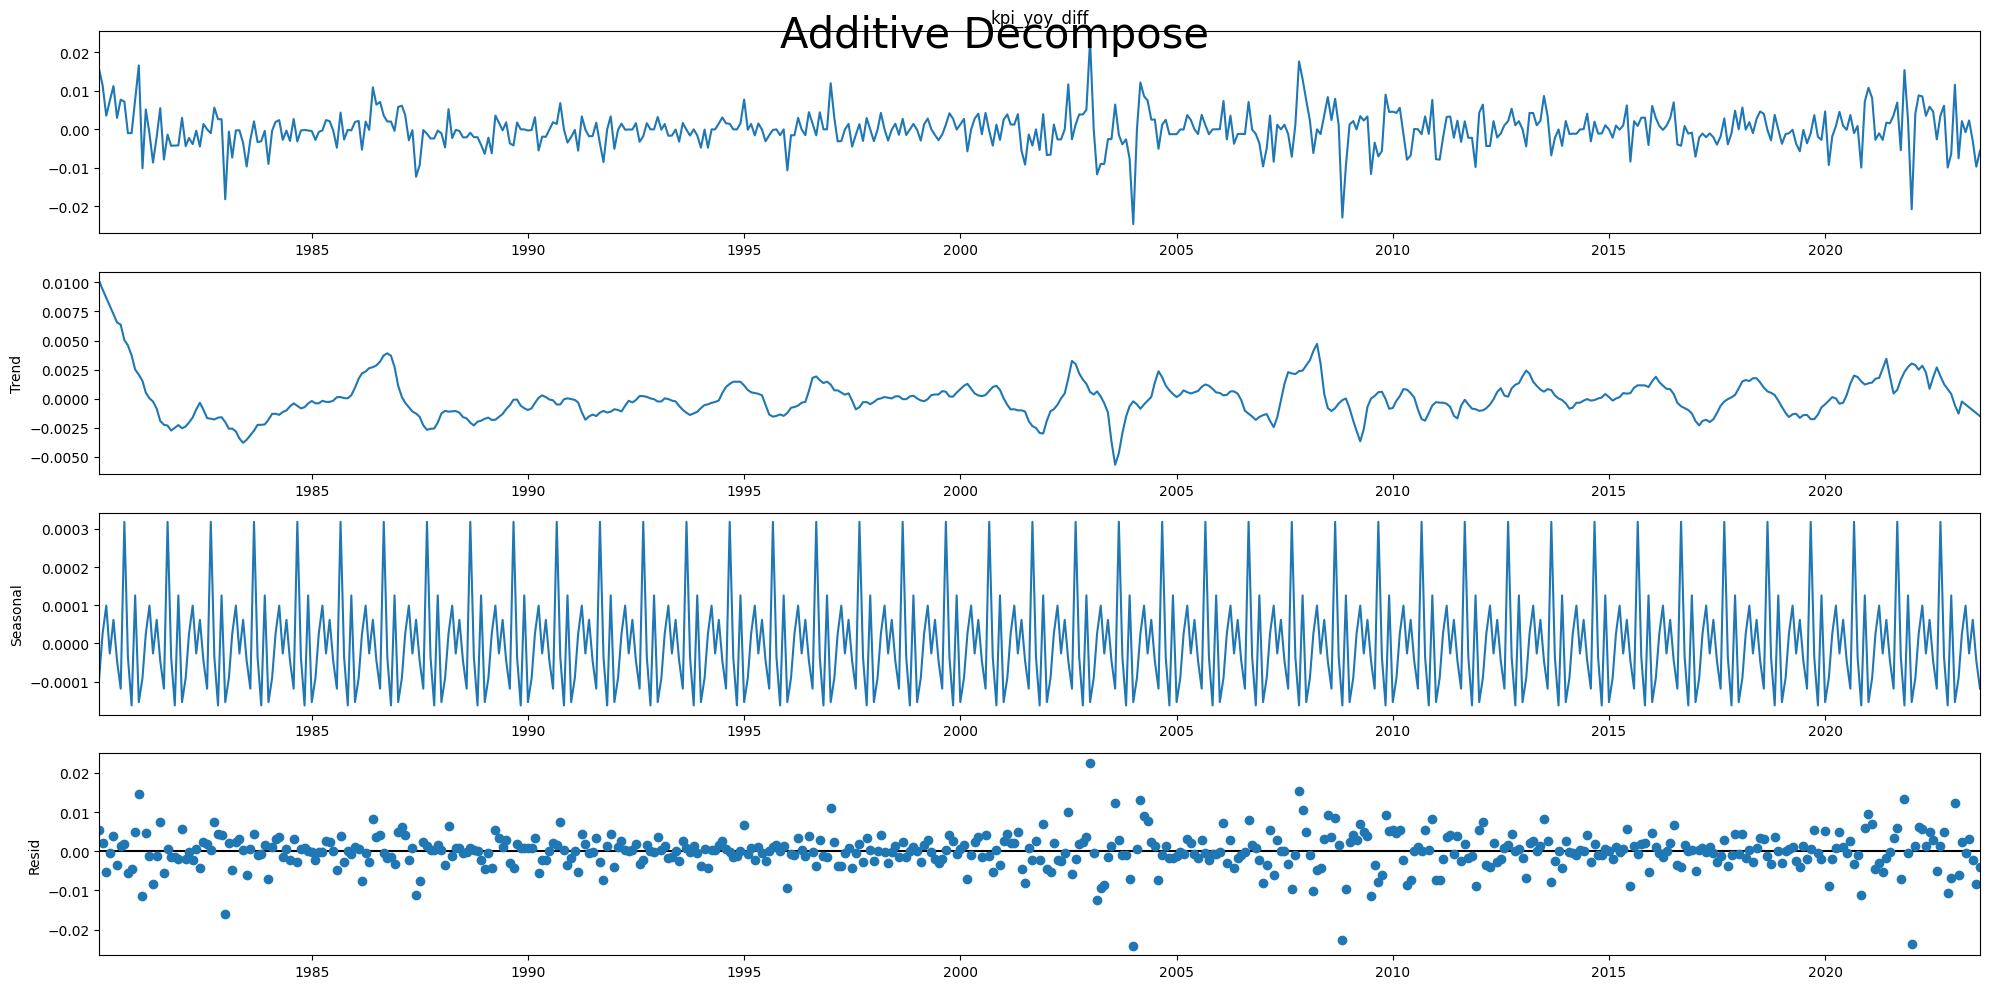

In [20]:
result_add_kpi = decompose(df1, 'kpi_yoy_diff')

In [21]:
df['ledighet_seasonal'] = result_add_ledighet.seasonal
df['ledighet_trend'] = result_add_ledighet.trend
df['ledighet_resid'] = result_add_ledighet.resid

df1['kpi_seasonal'] = result_add_kpi.seasonal
df1['kpi_trend'] = result_add_kpi.trend
df1['kpi_resid'] = result_add_kpi.resid

df = pd.concat([df, df1], axis=1)

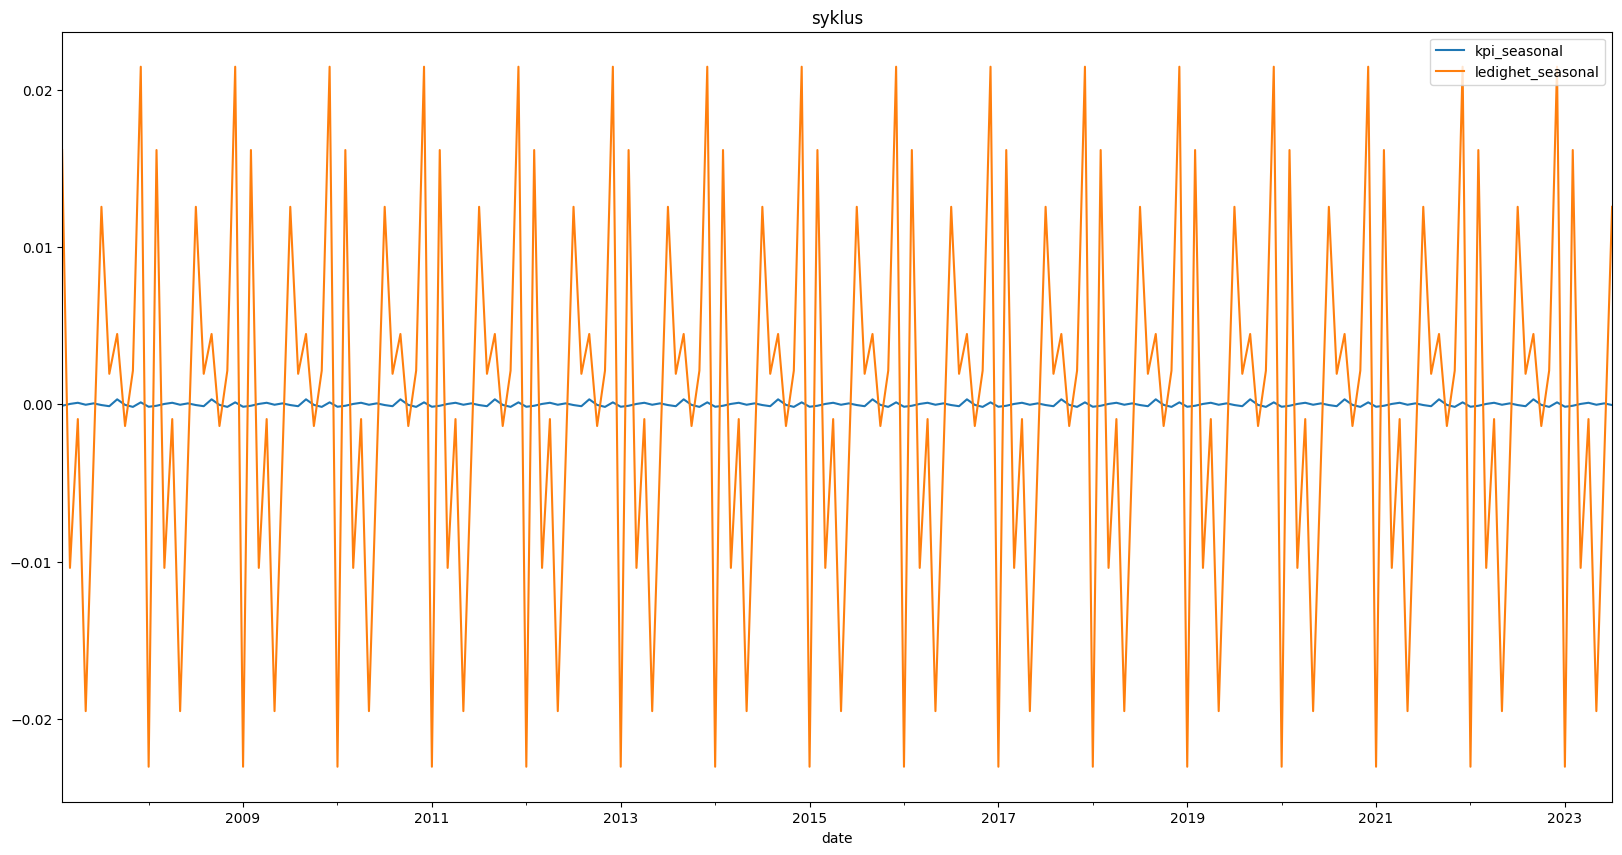

In [22]:
df.dropna().plot(y=['kpi_seasonal', 'ledighet_seasonal'], title='syklus')
plt.show()

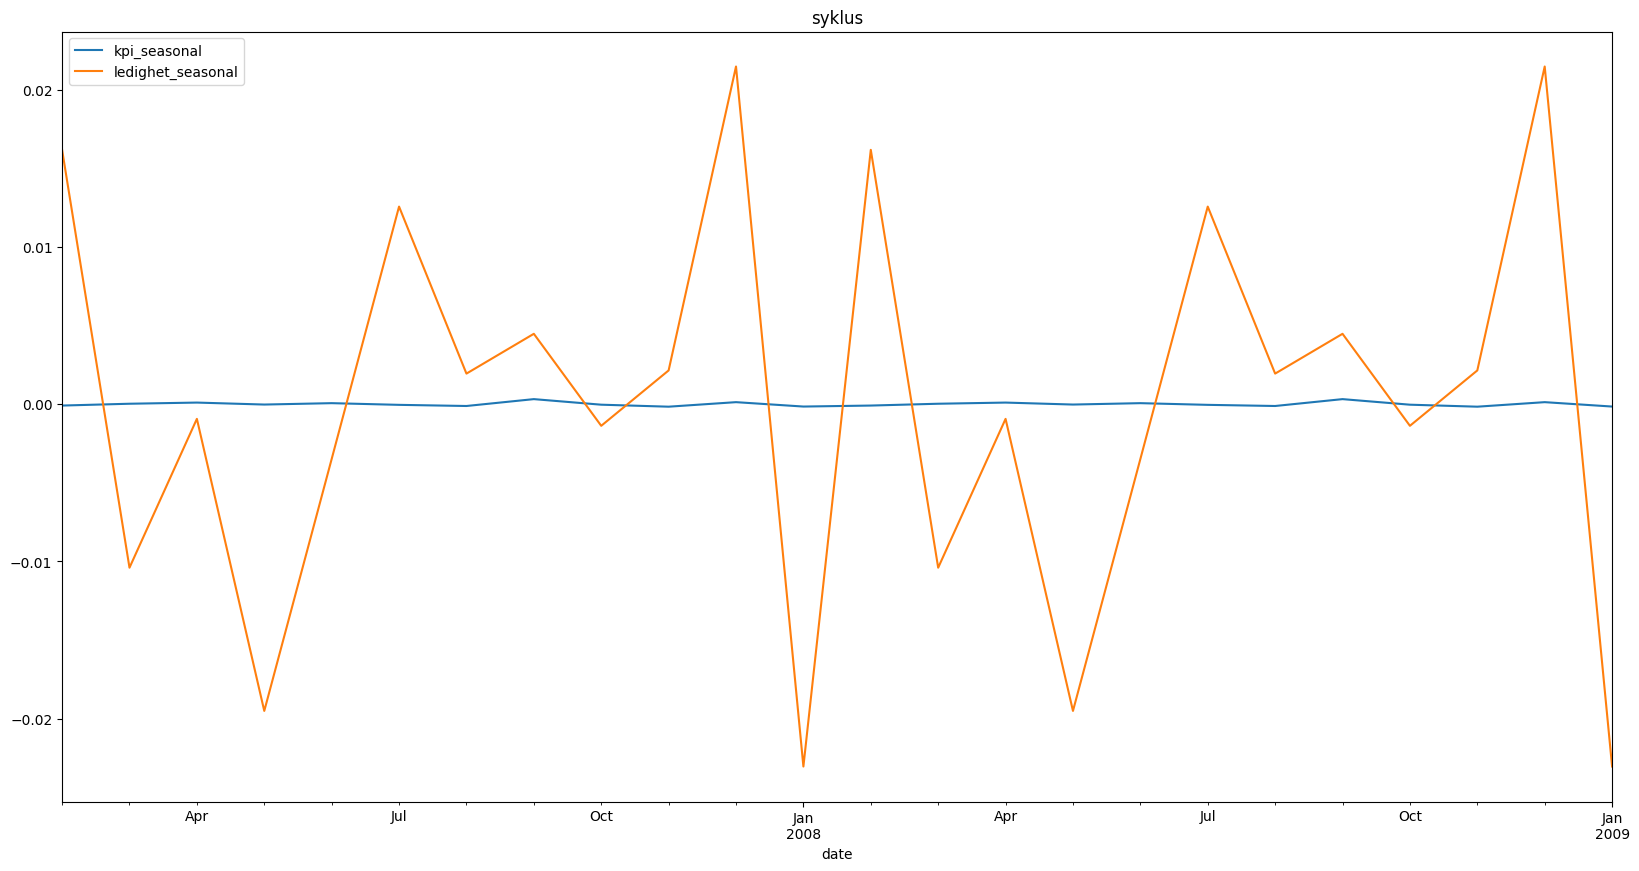

In [23]:
df.dropna().iloc[:24,:].plot(y=['kpi_seasonal', 'ledighet_seasonal'], title='syklus')
plt.show()

Årlige sykler i begge variabler! Merk komponenten er ganske liten.

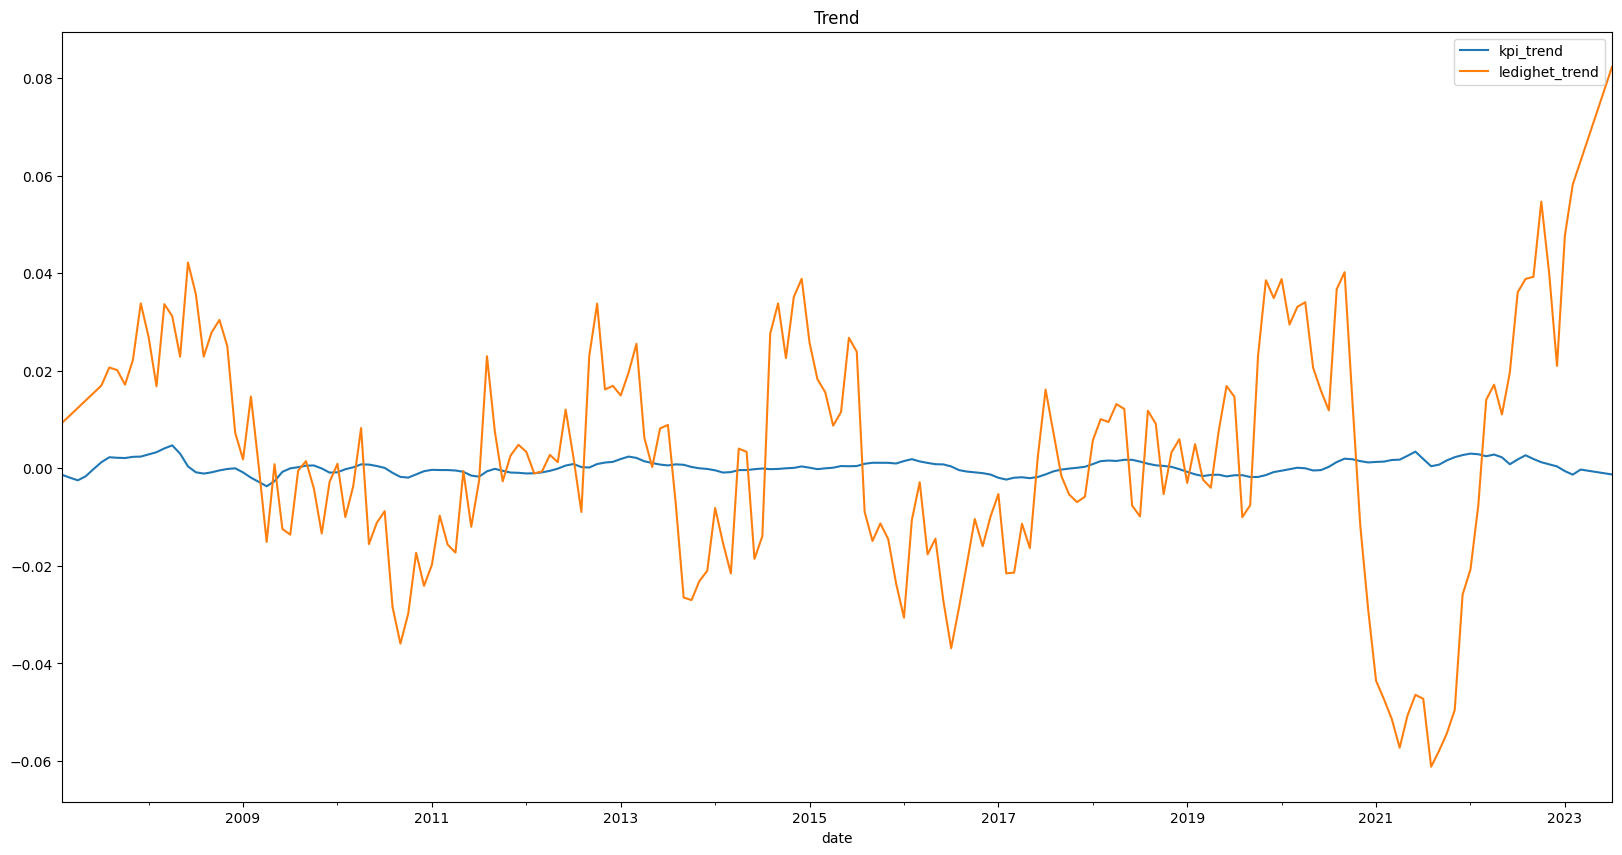

In [24]:
df.dropna().plot(y=['kpi_trend', 'ledighet_trend'], title='Trend')
plt.show()

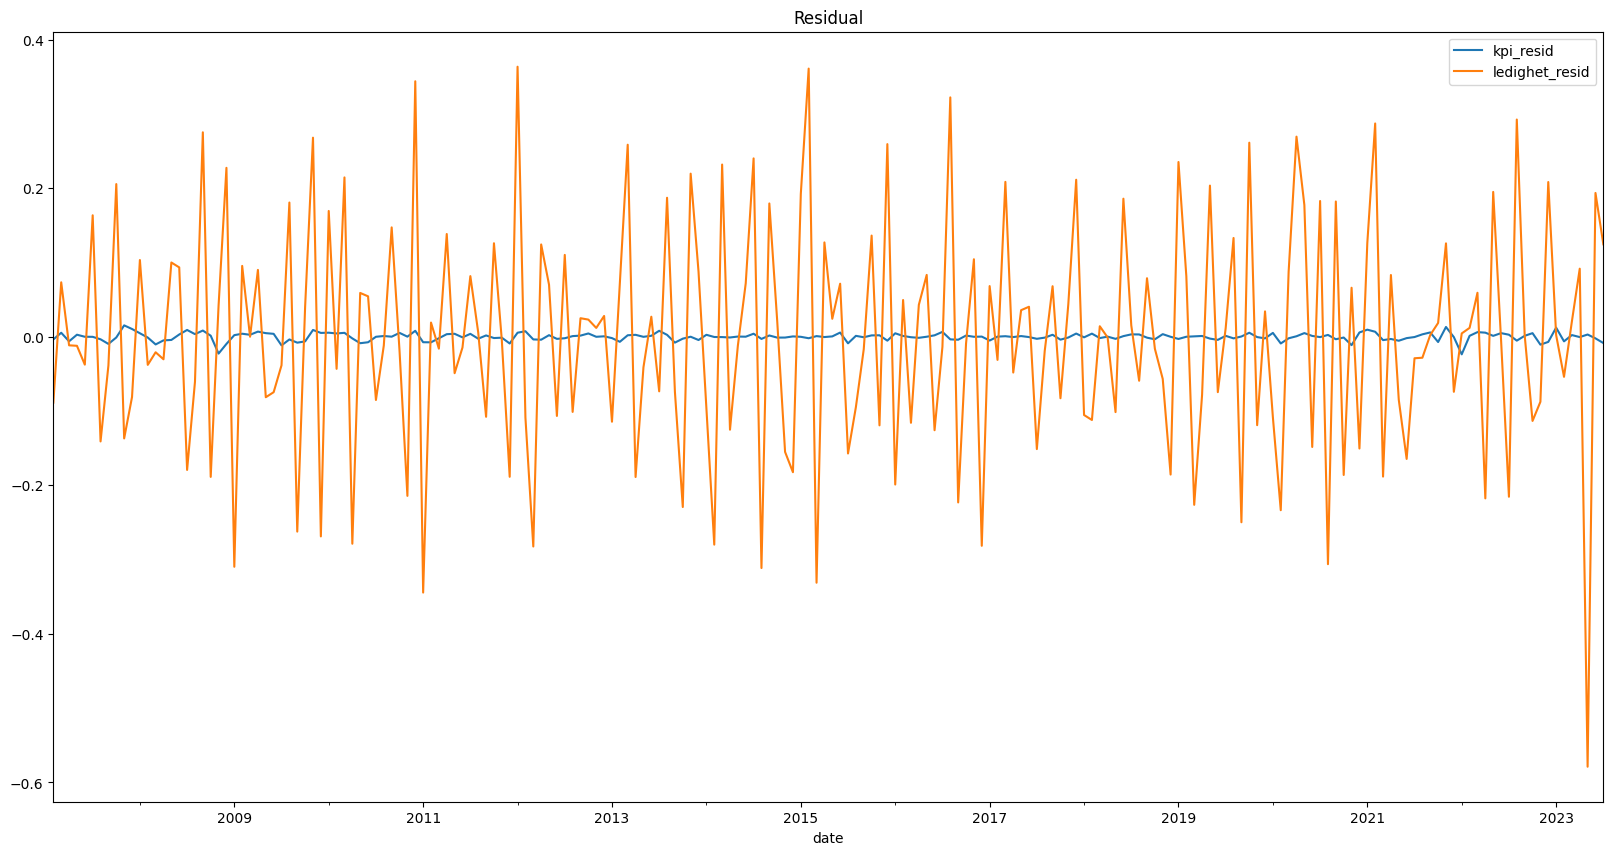

In [25]:
df.dropna().plot(y=['kpi_resid', 'ledighet_resid'], title='Residual')
plt.show()

In [26]:
df.corr().style.background_gradient(cmap='viridis')

,ledighet,ledighet_yoy,ledighet_yoy_diff,ledighet_seasonal,ledighet_trend,ledighet_resid,kpi,kpi_yoy,kpi_yoy_diff,kpi_seasonal,kpi_trend,kpi_resid
ledighet,1.000000,0.507732,0.116218,-0.097842,-0.357523,0.183092,0.305156,-0.055675,0.034141,0.032461,-0.008491,0.035839
ledighet_yoy,0.507732,1.000000,0.398255,0.030558,0.029310,0.393827,-0.095975,-0.047113,0.030594,0.005073,-0.100314,0.057806
ledighet_yoy_diff,0.116218,0.398255,1.000000,0.078745,0.104030,0.983768,0.011215,0.011480,0.046752,0.019963,-0.011420,0.049634
ledighet_seasonal,-0.097842,0.030558,0.078745,1.000000,-0.008951,0.000000,-0.002566,-0.009653,-0.027959,0.239991,0.003745,-0.035140
ledighet_trend,-0.357523,0.029310,0.104030,-0.008951,1.000000,-0.057169,0.120411,0.212370,-0.033290,0.004443,-0.019222,-0.028404
ledighet_resid,0.183092,0.393827,0.983768,0.000000,-0.057169,1.000000,-0.008085,-0.022202,0.054754,0.000000,-0.008677,0.057441
kpi,0.305156,-0.095975,0.011215,-0.002566,0.120411,-0.008085,1.000000,-0.595691,0.016709,-0.002677,0.061775,-0.005683
kpi_yoy,-0.055675,-0.047113,0.011480,-0.009653,0.212370,-0.022202,-0.595691,1.000000,0.075132,0.002952,0.035113,0.065634
kpi_yoy_diff,0.034141,0.030594,0.046752,-0.027959,-0.033290,0.054754,0.016709,0.075132,1.000000,0.028565,0.310730,0.933018
kpi_seasonal,0.032461,0.005073,0.019963,0.239991,0.004443,0.000000,-0.002677,0.002952,0.028565,1.000000,0.004382,0.000000


# la oss forsøke å bygge en bedre modell

In [27]:
import statsmodels.api as sm

In [28]:
df = df.dropna()
df

,ledighet,ledighet_yoy,ledighet_yoy_diff,ledighet_seasonal,ledighet_trend,ledighet_resid,kpi,kpi_yoy,kpi_yoy_diff,kpi_seasonal,kpi_trend,kpi_resid
date,,,,,,,,,,,,
2007-02-01,0.028,-0.348837,-0.063123,0.016174,0.009330,-0.088627,84.0,0.007194,-0.004898,-0.000090,-0.001324,-0.003483
2007-03-01,0.029,-0.275000,0.073837,-0.010403,0.010863,0.073377,84.5,0.010766,0.003571,0.000025,-0.001914,0.005460
2007-04-01,0.029,-0.275000,0.000000,-0.000937,0.012395,-0.011458,84.5,0.002372,-0.008393,0.000099,-0.002455,-0.006037
2007-05-01,0.029,-0.292683,-0.017683,-0.019512,0.013928,-0.012098,84.6,0.003559,0.001186,-0.000026,-0.001620,0.002832
2007-06-01,0.030,-0.318182,-0.025499,-0.003492,0.015461,-0.037468,84.5,0.003563,0.000004,0.000062,-0.000142,0.000084
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-01,0.038,0.187500,0.073214,-0.010403,0.063030,0.020587,127.6,0.065109,0.002136,0.000025,-0.000248,0.002359
2023-04-01,0.035,0.346154,0.158654,-0.000937,0.067861,0.091730,129.0,0.064356,-0.000752,0.000099,-0.000499,-0.000352
2023-05-01,0.032,-0.179487,-0.525641,-0.019512,0.072692,-0.578821,129.6,0.066667,0.002310,-0.000026,-0.000750,0.003087


In [29]:
def create_lag(df, num=1):
    new_df = df.copy()
    for i in range(1,num +1):
        lag_df = df.shift(i)
        lag_df.columns = [f"{col}_lag{i}" for col in df.columns]
        new_df = pd.concat([new_df, lag_df], axis=1)
    return new_df

In [30]:
# df[['kpi_trend_l1', 'kpi_seasonal_l1', 'kpi_resid_l1', 'ledighet_trend_l1', 'ledighet_seasonal_l1', 'ledighet_resid_l1']] = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid', 'ledighet_trend', 'ledighet_seasonal', 'ledighet_resid']].shift(1)
# df[['kpi_trend_l2', 'kpi_seasonal_l2', 'kpi_resid_l2', 'ledighet_trend_l2', 'ledighet_seasonal_l2', 'ledighet_resid_l2']] = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid', 'ledighet_trend', 'ledighet_seasonal', 'ledighet_resid']].shift(2)
# df[['kpi_trend_l3', 'kpi_seasonal_l3', 'kpi_resid_l3', 'ledighet_trend_l3', 'ledighet_seasonal_l3', 'ledighet_resid_l3']] = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid', 'ledighet_trend', 'ledighet_seasonal', 'ledighet_resid']].shift(3)
# df[['kpi_trend_l4', 'kpi_seasonal_l4', 'kpi_resid_l4', 'ledighet_trend_l4', 'ledighet_seasonal_l4', 'ledighet_resid_l4']] = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid', 'ledighet_trend', 'ledighet_seasonal', 'ledighet_resid']].shift(4)

# df = df.dropna()
 
# X = df[['ledighet_trend', 'ledighet_seasonal', 'ledighet_resid','ledighet_trend_l1', 'ledighet_seasonal_l1', 'ledighet_resid_l1','ledighet_trend_l2', 'ledighet_seasonal_l2', 'ledighet_resid_l2','ledighet_trend_l3', 'ledighet_seasonal_l3', 'ledighet_resid_l3','ledighet_trend_l4', 'ledighet_seasonal_l4', 'ledighet_resid_l4']]


# X = df[['ledighet_seasonal', 'ledighet_trend', 'ledighet_resid']]
X = df[['ledighet_trend','ledighet_trend_l1']]
y = df['kpi_yoy']

X = sm.add_constant(X, prepend=False)

# Fit and summarize OLS model
mod = sm.OLS(y, X)

res = mod.fit(cov_type='HC3')

print(res.summary())

KeyError: "['ledighet_trend_l1'] not in index"

Når trenden til endringen i ledighet øker med 100 prosentpoeng vil forventes inflajonen å øke med 13.5 prosentpoeng

In [ ]:
plt.plot(res.resid)
plt.show()
plt.hist(res.resid)
plt.show()

# PLS (Eksempel på keep it simple stupid!)

In [ ]:
from sklearn.cross_decomposition import PLSRegression

In [ ]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()

df[['kpi_trend_l1', 'kpi_seasonal_l1', 'kpi_resid_l1', 'ledighet_trend_l1', 'ledighet_seasonal_l1', 'ledighet_resid_l1']] = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid', 'ledighet_trend', 'ledighet_seasonal', 'ledighet_resid']].shift(1)
df[['kpi_trend_l2', 'kpi_seasonal_l2', 'kpi_resid_l2', 'ledighet_trend_l2', 'ledighet_seasonal_l2', 'ledighet_resid_l2']] = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid', 'ledighet_trend', 'ledighet_seasonal', 'ledighet_resid']].shift(2)
df[['kpi_trend_l3', 'kpi_seasonal_l3', 'kpi_resid_l3', 'ledighet_trend_l3', 'ledighet_seasonal_l3', 'ledighet_resid_l3']] = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid', 'ledighet_trend', 'ledighet_seasonal', 'ledighet_resid']].shift(3)
df[['kpi_trend_l4', 'kpi_seasonal_l4', 'kpi_resid_l4', 'ledighet_trend_l4', 'ledighet_seasonal_l4', 'ledighet_resid_l4']] = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid', 'ledighet_trend', 'ledighet_seasonal', 'ledighet_resid']].shift(4)


df = df.dropna()

X_cols = df[['ledighet_trend', 'ledighet_seasonal', 'ledighet_resid','ledighet_trend_l1', 'ledighet_seasonal_l1', 'ledighet_resid_l1','ledighet_trend_l2', 'ledighet_seasonal_l2', 'ledighet_resid_l2','ledighet_trend_l3', 'ledighet_seasonal_l3', 'ledighet_resid_l3','ledighet_trend_l4', 'ledighet_seasonal_l4', 'ledighet_resid_l4']].columns
Y_cols = df[['kpi_trend', 'kpi_seasonal', 'kpi_resid']].columns

X = x_scaler.fit_transform(df[['ledighet_trend', 'ledighet_seasonal', 'ledighet_resid','ledighet_trend_l1', 'ledighet_seasonal_l1', 'ledighet_resid_l1','ledighet_trend_l2', 'ledighet_seasonal_l2', 'ledighet_resid_l2','ledighet_trend_l3', 'ledighet_seasonal_l3', 'ledighet_resid_l3','ledighet_trend_l4', 'ledighet_seasonal_l4', 'ledighet_resid_l4']])
Y = y_scaler.fit_transform(df[['kpi_trend', 'kpi_seasonal', 'kpi_resid']])

In [ ]:
model1 = PLSRegression()
model1.fit(X,Y)

In [ ]:
print(np.round(model1.intercept_, 3))
print(np.round(model1.coef_,3))
print(np.round(model1.score(X,Y),3))

In [ ]:
pd.DataFrame(np.round(model1.coef_,3), columns=Y_cols, index=X_cols)

In [ ]:
from sklearn.metrics import r2_score

Y_pred = model1.predict(X)
Y_pred = y_scaler.inverse_transform(Y_pred)

r2_score(df['kpi_yoy'],y_pred)

Ser at forklaringskraften er betraklig værre enn ved enkel OLS regression. KISS <3. (Keep It Simple Stupid)

In [ ]:
y_pred = vector = np.sum(Y_pred, axis=1)
plt.plot(df.index,y_pred, label='predicted')
plt.plot(df['kpi_yoy'], label='true')
plt.legend()
plt.title("Doesn't really predict anything")
plt.show()

In [ ]:
plt.scatter(df['kpi_yoy'],y_pred)
plt.axline([0.025, 0.025], [0.026, 0.026], color='red', linestyle=':', label='45 degree line')
plt.xlabel('true')
plt.ylabel('predicted')
plt.show()